# Quickstart Example with Synthetic RTB Simulation and Dataset (Data Collection)
This notebook provides an example of visualizing logged dataset collected on RTB environment.

Our example with Synthetic RTB Simualtion and Dataset contains the following 2 cases:
1. Discrete Action Case
2. Continuous Action Case

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  
\* Also, our implementations of the data collection module is highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import offlinegym modules
import offlinegym
from rtbgym import RTBEnv, CustomizedRTBEnv
from offlinegym.dataset import SyntheticDataset
from offlinegym.policy import OnlineHead
from offlinegym.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

In [5]:
import pickle
from dataclasses import dataclass
from typing import Tuple, Union, Optional
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(offlinegym.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 0. Description of Synthetic RTB Simulation Environment
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as numbers of click or conversion) within a episode under the given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we adjust bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe statistical feedback from environment at each timestep, which include following informations.
  - timestep
  - remaining budget
  - impression level features (budget comsuption rate, cost per mille of impressions, auction winning rate, reward) at previous timestep
  - adjust rate (RL agent's decision making) at previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [8]:
# setup environment
env = RTBEnv(random_state=random_state)

In [9]:
# define random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    )
)

In [10]:
# interact agent with environment
# only 6 lines needed for RL interaction
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [11]:
# state contains the following statistical feedback from environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


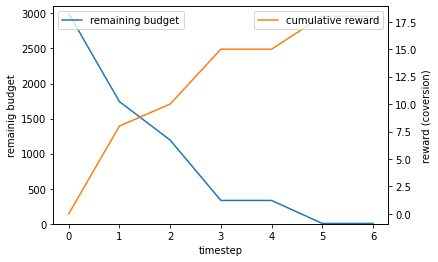

In [12]:
# let's visualize the transition of remaing budget and cumulative reward
# our goal is to gain a policy (i.e., agent) which maximize the cumulative reward under budget constraints using RL.  
# for more visulization, please see appendix.
obs = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

For more about the environmental configuration , please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

## 1. Discrete Action Case
Here, we present how to collect logged data by a discrete behavior policy.

The procedure requires two steps:

1. Learn a base deterministic policy
2. Convert the deterministic policy into a stochastic policy.

Below, we first learn a deterministic policy using [d3rlpy](https://github.com/takuseno/d3rlpy).

In [13]:
# setup discrete environment
env = CustomizedRTBEnv(
    original_env=RTBEnv(random_state=random_state),
    reward_predictor=LogisticRegression(),
    action_type="discrete",
)

In [14]:
# learn base deterministic policy for data collection
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [15]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
)

2022-05-25 13:49.53 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20220525134953
2022-05-25 13:49.53 [debug    ] Building model...
2022-05-25 13:49.53 [debug    ] Model has been built.
2022-05-25 13:49.53 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20220525134953/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (7,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2022-05-25 13:49.55 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220525134953/model_1000.pt
2022-05-25 13:49.55 [info     ] DoubleDQN_online_20220525134953: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0003160154819488525, 'time_environment_step': 0.0006224339008331299, 'time_step': 0.002291670560836792, 'rollout_return': 11.028169014084508, 'time_sample_batch': 7.473325285571314e-05, 'time_algorithm_update': 0.0012656148241865597, 'loss': 109.75924335665145, 'evaluation': 4.8} step=1000
2022-05-25 13:49.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20220525134953/model_2000.pt
2022-05-25 13:49.58 [info     ] DoubleDQN_online_20220525134953: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00029101347923278807, 'time_environment_step': 0.0005795955657958984, 'time_sample_batch': 7.070493698120117e-05, 'time_algorithm_update': 0.0011878294944763185, 'loss': 39.042923963546755, 'time_step': 0.002183726072311401, 'rol

In [16]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [17]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2022-05-25 13:53.40 [warning  ] Parameters will be reinitialized.


### 1.1. Epsilon-Greedy behavior policy

Let's now convert the deterministic policy (i.e., ddqn policy) into a stochstic behavior policy.

We use epsilon-greedy policy to collect logged data using `DiscreteEpsilonGreedyHead`, \
where the behavior policy greedy takes action chosen by the deterministic policy with probability $1 - \epsilon$ and takes action randomly with probability $\epsilon$.

In [18]:
# convert base ddqn policy into a stochastic data collection policy
from offlinegym.policy import DiscreteEpsilonGreedyHead

behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [19]:
# collect data
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.29616093e-01, ...,
         1.83918812e-01, 2.00000000e+00, 4.83864573e-01],
        [1.00000000e+00, 1.94100000e+03, 3.53000000e-01, ...,
         1.00000000e+00, 6.00000000e+00, 1.00000000e+01],
        [2.00000000e+00, 1.94100000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 2.40000000e+01, 9.54022989e-01, ...,
         5.55555556e-01, 2.00000000e+00, 5.99484250e+00],
        [5.00000000e+00, 

In [21]:
# check statistics of the dataset
# we see that the environment is highly stochstic and the reward is sparse
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,3.303682,183.348294,70.248486,7.171743,1.815071,0.398028,0.051454,0.112338
std,4.148192,217.790096,88.442097,9.436952,2.950118,0.435017,0.068769,0.174092
min,0.000093,4.050761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166810,7.881720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.774264,36.383811,5.000000,0.000000,0.000000,0.183107,0.000000,0.000000
75%,10.000000,474.491573,176.000000,16.000000,3.000000,0.996319,0.100503,0.200000
max,11.130905,555.903614,290.000000,42.000000,20.000000,1.000000,0.999995,0.999998


In [22]:
# aggeregate episodic statistics
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['ramaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.303682,183.348294,70.248486,7.171743,1.815071,713.373800
std,1.450104,81.460791,20.768412,2.162194,0.700917,760.608003
min,0.250684,11.803092,1.000000,0.285714,0.000000,1.000000
25%,1.980807,109.415171,57.714286,5.428571,1.285714,20.000000
50%,3.137944,176.630340,76.428571,8.285714,1.857143,421.000000
75%,4.430329,242.048569,85.571429,8.714286,2.285714,1374.000000
max,8.028057,438.848162,120.428571,10.428571,4.285714,2949.000000


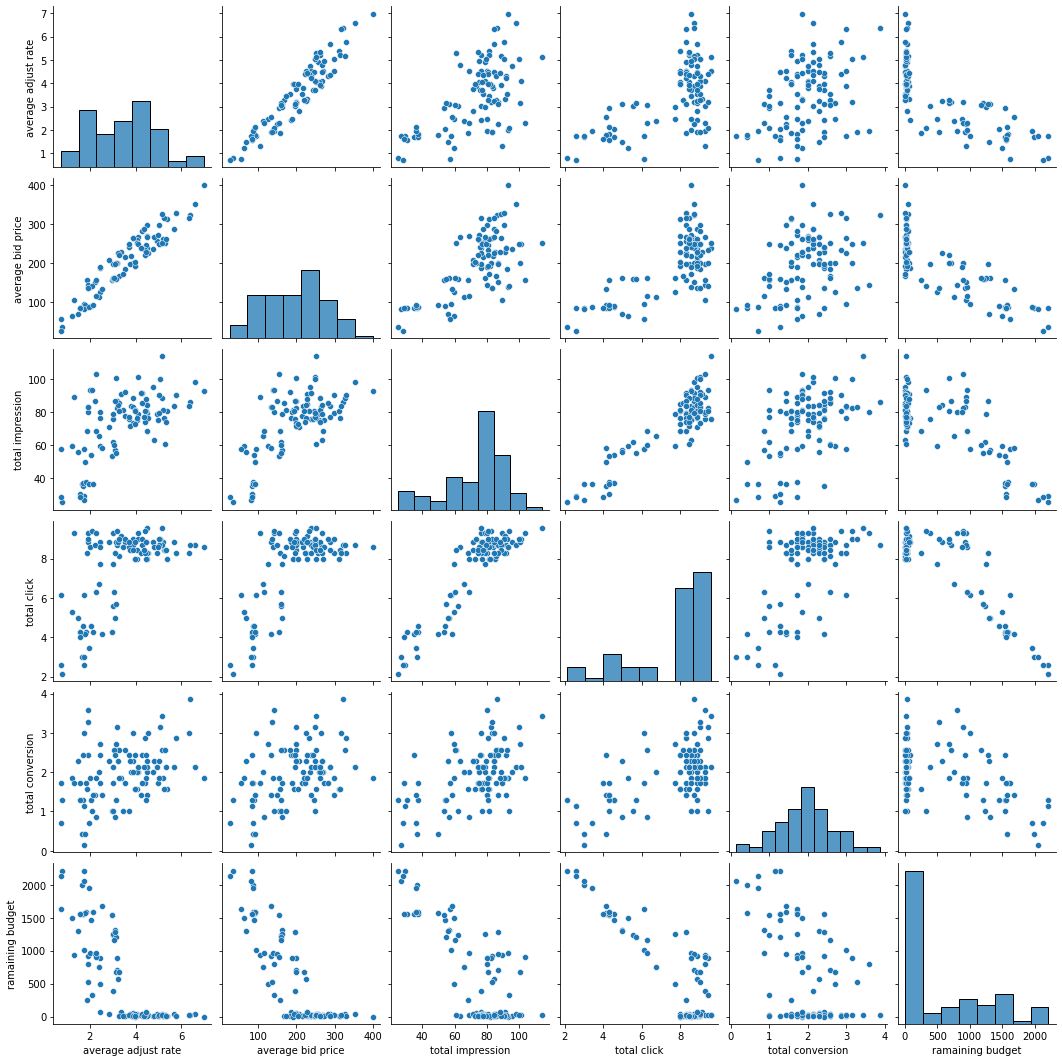

In [23]:
# we see a strong correlation between number of impression and click.
# However, large number of click does not necessarily lead to conversion.
sns.pairplot(df_[:100])

### 1.2. Softmax behavior policy
We can also use `DiscreteSoftmaxHead` to derive a stochastic behavior policy.

This algorithm uses Q function of the original algorithm, which estimates the value of given context and action pair (i.e., $(s, a)$) as $Q(s, a)$. \
Specifically, the behavior policy chooses actions stochastically as $\pi(a \mid s) = \frac{\exp(Q(s, a) / \tau)}{\sum_{a' \in A} \exp(Q(s, a') / \tau)}$, where $A$ indicates the set discrete actions and $\tau$ is a inverse temprature parameter.

In [24]:
# convert base ddqn policy into a stochastic data collection policy
from offlinegym.policy import DiscreteSoftmaxHead

behavior_policy = DiscreteSoftmaxHead(
    ddqn, 
    n_actions=env.action_space.n,
    tau=1.0,  # temperature parameter
    name="ddqn_softmax_tau_1.0",
    random_state=random_state,
)

In [25]:
# collect data
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.29616093e-01, ...,
         1.83918812e-01, 2.00000000e+00, 3.46994463e-01],
        [1.00000000e+00, 1.94100000e+03, 3.53000000e-01, ...,
         1.00000000e+00, 6.00000000e+00, 1.00000000e+01],
        [2.00000000e+00, 1.94100000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 3.19000000e+02, 7.72142857e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+00],
        [5.00000000e+00, 

In [27]:
# check statistics of the dataset
# we see that the environment is highly stochstic and the reward is sparse
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,3.086691,168.799905,71.917857,7.392129,1.868671,0.403501,0.059799,0.119159
std,3.958522,208.629174,88.207639,9.495021,2.970639,0.431594,0.079870,0.180911
min,0.000013,3.995690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166810,8.227875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.774264,37.180500,8.000000,1.000000,0.000000,0.218455,0.027027,0.000000
75%,5.994843,301.966573,177.000000,16.000000,3.000000,0.994872,0.105634,0.214286
max,10.000000,555.903614,290.000000,43.000000,20.000000,1.000000,0.999997,0.999998


In [28]:
# aggeregate episodic statistics
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['ramaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.086691,168.799905,71.917857,7.392129,1.868671,674.638800
std,1.276602,68.726044,20.888127,2.125386,0.698672,809.281211
min,0.144455,6.433112,0.000000,0.000000,0.000000,1.000000
25%,1.990720,111.983679,61.142857,6.285714,1.428571,21.000000
50%,3.057461,164.785475,77.285714,8.428571,1.857143,155.500000
75%,3.924595,216.496249,86.714286,8.857143,2.285714,1298.000000
max,8.639013,500.621486,121.428571,10.285714,4.428571,3000.000000


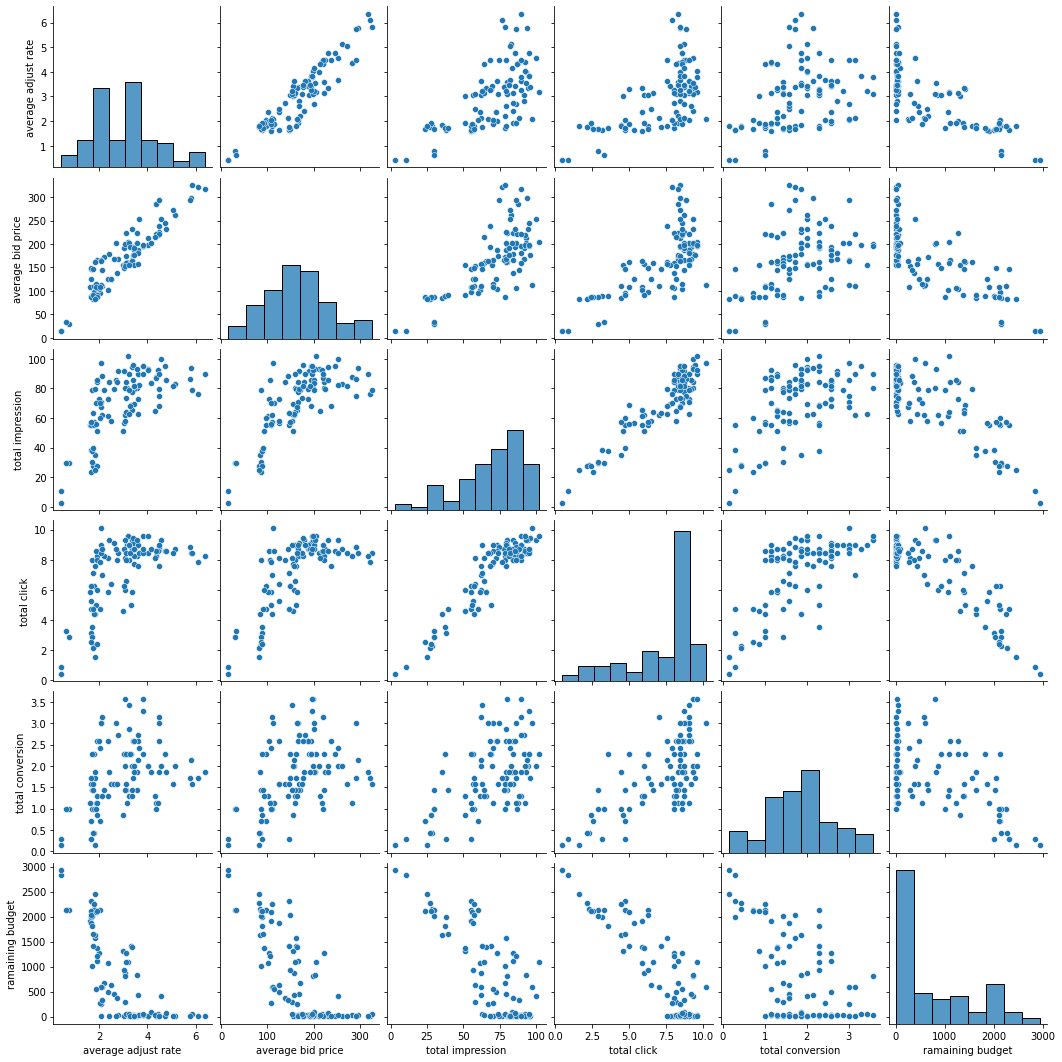

In [29]:
# seems softmax policy obtain impression more, but conversion less than the epsilon-greedy policy
sns.pairplot(df_[:100])

For offline RL and OPE procedures, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/master/examples/quickstart/rtb_synthetic_discrete_basic.ipynb).\
For more advanced topic in OPE and OPS, please refer to [examples/quickstart/rtb_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_advanced.ipynb).

## 2. Continuous Action Space
We also describe the case where the continuous behavior policy is used. \
Here, we first learn a base deterministic policy in a similar manner with discrete action case.

In [30]:
# setup discrete environment
env = CustomizedRTBEnv(
    original_env=RTBEnv(random_state=random_state),
    reward_predictor=LogisticRegression(),
    action_type="continuous",
)

In [31]:
# learn base deterministic policy for data collection
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 0.1
        maximum=env.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)

In [32]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
)

2022-05-25 13:56.03 [info     ] Directory is created at d3rlpy_logs/SAC_online_20220525135603
2022-05-25 13:56.03 [debug    ] Fitting action scaler...       action_scler=min_max
2022-05-25 13:56.03 [debug    ] Building model...
2022-05-25 13:56.03 [debug    ] Model has been built.
2022-05-25 13:56.03 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20220525135603/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense'

  0%|          | 0/100000 [00:00<?, ?it/s]

2022-05-25 13:56.08 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220525135603/model_1000.pt
2022-05-25 13:56.09 [info     ] SAC_online_20220525135603: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0005665798187255859, 'time_environment_step': 0.000668734073638916, 'time_step': 0.005529204607009888, 'rollout_return': 13.626760563380282, 'time_sample_batch': 0.00023861271536045409, 'time_algorithm_update': 0.005458211834626435, 'temp_loss': -5.247534716755031, 'temp': 1.0680625650475195, 'critic_loss': 1918.958381591222, 'actor_loss': 7.910422518829318, 'evaluation': 14.7} step=1000
2022-05-25 13:56.15 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20220525135603/model_2000.pt
2022-05-25 13:56.15 [info     ] SAC_online_20220525135603: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0005593748092651367, 'time_environment_step': 0.0006514434814453125, 'time_sample_batch': 0.00023232007026672364, 'time_algorithm_update': 0.005173914432

In [33]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [34]:
# reload model
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

2022-05-25 14:08.12 [warning  ] Parameters will be reinitialized.


### 2.1. Gaussian behavior policy

Then, we convert a deterministic policy (i.e., greedy action choice of sac policy) into a stochastic policy. 

As the action space of `RTBEnv` is bounded, we use `ContinuousTruncatedGaussianHead`. \
Given the deterministic action $\pi(s)$, this behavior policy samples actions from a truncated gaussian distribution as $a \sim Truncnorm(\pi(s), \sigma)$, where $\sigma$ indicates the noise level. 

Note that, when action space is not bounded, we can use `ContinuousGaussianHead` in a similar manner.

In [35]:
# convert base ddqn policy into a stochastic data collection policy
from offlinegym.policy import ContinuousTruncatedGaussianHead

behavior_policy = ContinuousTruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,  # lower bound of the action space
    maximum=env.action_space.high,  # upper bound of the action space
    sigma=np.array([1.0]),  # noise level of a gaussian distribution
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [36]:
# collect data
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 1,
 'action_meaning': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.29616093e-01, ...,
         1.83918812e-01, 2.00000000e+00, 3.99551291e+00],
        [1.00000000e+00, 1.99800000e+03, 3.34000000e-01, ...,
         1.00000000e+00, 6.00000000e+00, 9.85711832e+00],
        [2.00000000e+00, 1.30800000e+03, 3.45345345e-01, ...,
         1.00000000e+00, 1.00000000e+00, 3.95628656e+00],
        ...,
        [4.00000000e+00, 4.20000000e+01, 4.32432432e-01, ...,
         4.34782609e-02, 0.00000000e+00, 5.89633200e+00],
        [5.00000000e+00, 4.20000000e+01, 0.00000000e+00, ...,
         4.92610837e-03, 0.00000000e+00, 4.03121476e+00],
        [6.00000000e+00, 4.20000000e+01, 0.00

In [38]:
# check statistics of the dataset
# we see that the environment is highly stochstic and the reward is sparse, in a simmilar manner with discrete case
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,4.265916,235.901893,94.107729,8.817614,2.094571,0.537849,0.055897,0.125508
std,2.457029,117.453535,91.458627,9.650058,3.040623,0.434216,0.062216,0.177285
min,0.000017,4.235632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.823758,161.192975,6.000000,0.000000,0.000000,0.051163,0.000000,0.000000
50%,3.994089,208.202151,39.000000,2.000000,0.000000,0.591352,0.063584,0.000000
75%,5.160159,264.826530,192.000000,18.000000,3.000000,1.000000,0.099548,0.214286
max,9.999792,543.913462,290.000000,41.000000,20.000000,1.000000,0.999990,0.999997


In [39]:
# aggeregate episodic statistics
# compared to the discrete case, remeining budget is small, meaning that continuous case is more flexible
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
df_['ramaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramaining budget
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.265916,235.901893,94.107729,8.817614,2.094571,17.143600
std,0.473563,29.413743,10.862138,0.313246,0.486078,11.820192
min,2.705679,150.155429,55.714286,7.714286,0.428571,1.000000
25%,3.954733,217.133145,86.678571,8.571429,1.714286,7.000000
50%,4.233276,232.708416,93.285714,8.857143,2.142857,15.000000
75%,4.516940,249.706585,101.142857,9.000000,2.428571,26.000000
max,6.761867,383.926492,137.142857,10.000000,4.285714,72.000000


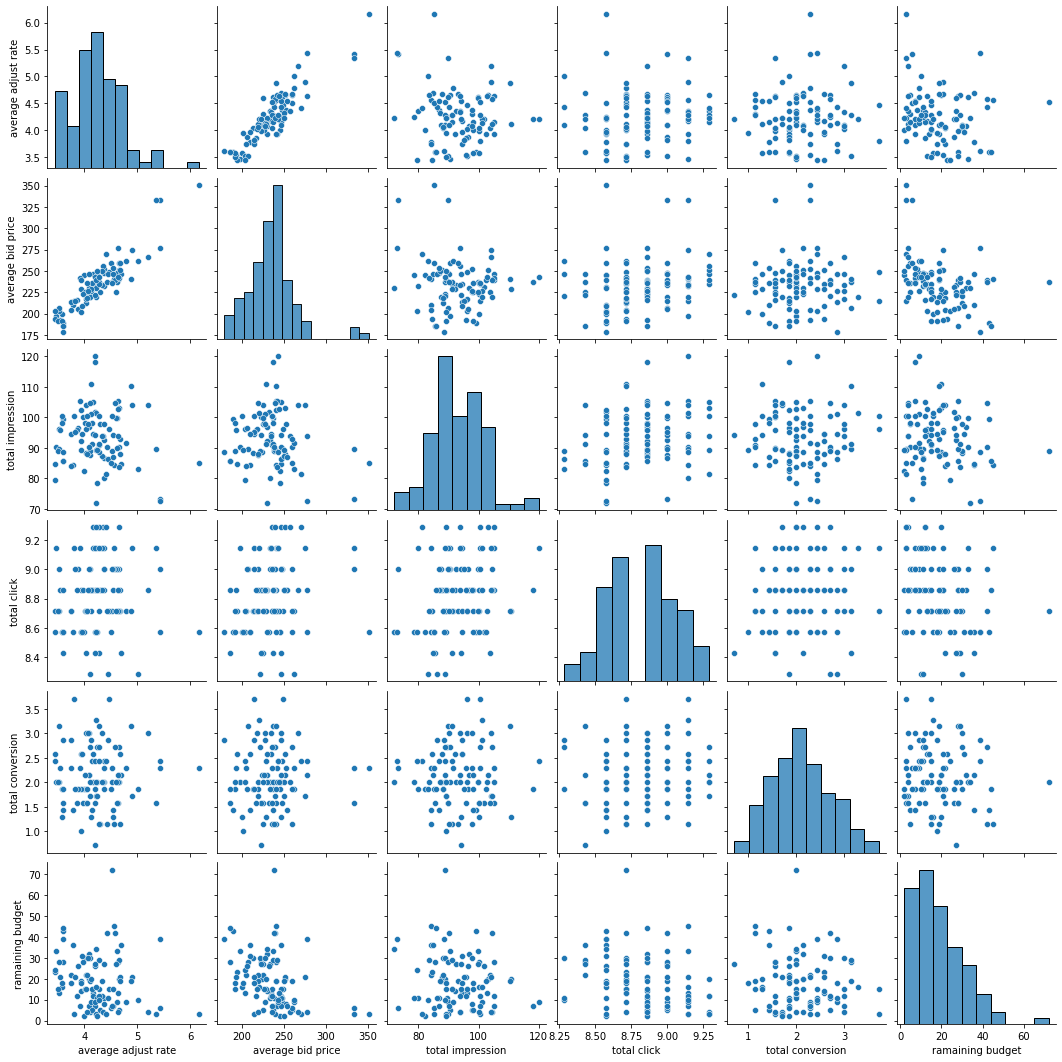

In [40]:
# the result reveals that there is slight negative correlation between bid price and impression
sns.pairplot(df_[:100])

For offline RL and OPE procedures, please refer to [examples/quickstart/rtb_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_basic.ipynb). \
For advanced topics in OPE and OPS, please refer to [examples/quickstart/rtb_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_advanced.ipynb).

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.